In [1]:
import requests
import json
import pandas as pd
import numpy as np
import dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime,timedelta

c:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Load secret file
dotenv.load_dotenv('.env')

headers = {
  "Authorization":f"apikey {os.environ.get('apikey')}"
}
url_carparks = 'https://api.transport.nsw.gov.au/v1/carpark'
# url_carpark_history = 'https://api.transport.nsw.gov.au/v1/carpark/history'

# Delete file if it exists
if os.path.exists('./data/carparks.json'):
  os.remove('./data/carparks.json')

list_of_carparks = requests.get(url_carparks, headers=headers).json()
# print(list_of_carparks)
# Create a json file and write the data if it doesn't exist
if not os.path.exists('./data/carparks.json'):
  with open('./data/carparks.json', 'w') as f:
    json.dump(list_of_carparks, f)

# The format of the file itself is a dictionary, thus requiring some creativity to read
with open('./data/carparks.json') as f:
  data = json.load(f)

# Convert the dictionary to a dataframe
df_carparks = pd.DataFrame.from_dict(data, orient='index')
# Resetting the index to label the columns afterwards
df_carparks = df_carparks.reset_index()
df_carparks.columns = ['facility_id', 'CarParkName']

df_carparks


,facility_id,CarParkName
0,1,Tallawong Station Car Park (historical only)
1,10,Warriewood Car Park
2,11,Narrabeen Car Park
3,12,Mona Vale Car Park
4,13,Dee Why Car Park
5,14,West Ryde Car Park
6,15,Sutherland East Parade Car Park
7,16,Leppington Car Park
8,17,Edmondson Park South Car Park
9,18,St Marys Car Park


Getting carpark structure

In [3]:

carpark_details_array = []
for index, row in df_carparks.iterrows():
  facility = row['facility_id']
  url = f'https://api.transport.nsw.gov.au/v1/carpark?facility={facility}'

  # Make request
  response = requests.get(url, headers=headers).json()

  # Add to array
  carpark_details_array.append(response)

carpark_details_array

[{'tsn': '2155384',
  'time': '742877319',
  'spots': '1004',
  'zones': [{'spots': '152',
    'zone_id': 'CPS-CUD1',
    'occupancy': {'loop': None,
     'total': '150',
     'monthlies': None,
     'open_gate': None,
     'transients': None},
    'zone_name': 'Tallawong Station At-Grade A Car Park',
    'parent_zone_id': '0'},
   {'spots': '455',
    'zone_id': 'CPS-CUD2',
    'occupancy': {'loop': None,
     'total': '455',
     'monthlies': None,
     'open_gate': None,
     'transients': None},
    'zone_name': 'Tallawong Station At-Grade B Car Park',
    'parent_zone_id': '0'},
   {'spots': '397',
    'zone_id': 'CPS-CUD3',
    'occupancy': {'loop': None,
     'total': '376',
     'monthlies': None,
     'open_gate': None,
     'transients': None},
    'zone_name': 'Tallawong Station At-Grade D Car Park',
    'parent_zone_id': '0'}],
  'ParkID': '1',
  'occupancy': {'loop': None,
   'total': '981',
   'monthlies': None,
   'open_gate': None,
   'transients': None},
  'MessageDate

In [4]:
# Saving carpark details to file
with open('./data/carpark_details.json', 'w') as f:
  json.dump(carpark_details_array, f)

# Reading as a dataframe
df_carpark_details = pd.read_json('./data/carpark_details.json')
df_carpark_details

,tsn,time,spots,zones,ParkID,occupancy,MessageDate,facility_id,facility_name,tfnsw_facility_id
0,2155384,742877319,1004,"[{'spots': '152', 'zone_id': 'CPS-CUD1', 'occu...",1,"{'loop': None, 'total': '981', 'monthlies': No...",2023-07-17T12:48:39,1,Tallawong Station Car Park,2155384CCP001
1,2101131,760740460,244,"[{'spots': '244', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '95', 'monthlies': Non...",2024-02-09T07:47:40,10,Warriewood Car Park,2101131TPR001
2,2101130,760740355,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '64269', 'total': '32', 'monthlies': ...",2024-02-09T07:45:55,11,Narrabeen Car Park,2101130TPR001
3,2103108,760740424,68,"[{'spots': '68', 'zone_id': '1', 'occupancy': ...",1,"{'loop': None, 'total': '62', 'monthlies': Non...",2024-02-09T07:47:04,12,Mona Vale Car Park,2103108TPR001
4,2099207,760740255,117,"[{'spots': '117', 'zone_id': '1', 'occupancy':...",1,"{'loop': '53878', 'total': '51', 'monthlies': ...",2024-02-09T07:44:15,13,Dee Why Car Park,2099207TPR001
5,211420,760740429,151,"[{'spots': '151', 'zone_id': '1', 'occupancy':...",1,"{'loop': '229630', 'total': '125', 'monthlies'...",2024-02-09T07:47:09,14,West Ryde Car Park,211420TPR001
6,223210,760740458,373,"[{'spots': '373', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '239', 'monthlies': No...",2024-02-09T07:47:38,15,Sutherland East Parade Car Park,223210TPR001
7,217933,760740372,1884,"[{'spots': '1884', 'zone_id': '1', 'occupancy'...",1,"{'loop': '818100', 'total': '741', 'monthlies'...",2024-02-09T07:46:12,16,Leppington Car Park,217933TPR001
8,217426,760740456,1429,"[{'spots': '1429', 'zone_id': '1', 'occupancy'...",1,"{'loop': '747635', 'total': '346', 'monthlies'...",2024-02-09T07:47:36,17,Edmondson Park South Car Park,217426TPR001
9,276010,760740403,682,"[{'spots': '682', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '268', 'monthlies': No...",2024-02-09T07:46:43,18,St Marys Car Park,276010TPR001


Deleting facility ids 486-490 as they will not be used. The source of the info indicates they contain inaccurate data for the columns that will be needed.

In [5]:
# Dropping rows 28,29,30,31,32
df_carpark_details.drop(index=[28,29,30,31,32],inplace=True)

# Resetting the index
df_carpark_details.reset_index(drop=True,inplace=True)

# Sorting by facility_id
df_carpark_details.sort_values(by='facility_id',inplace=True)
df_carpark_details

,tsn,time,spots,zones,ParkID,occupancy,MessageDate,facility_id,facility_name,tfnsw_facility_id
0,2155384,742877319,1004,"[{'spots': '152', 'zone_id': 'CPS-CUD1', 'occu...",1,"{'loop': None, 'total': '981', 'monthlies': No...",2023-07-17T12:48:39,1,Tallawong Station Car Park,2155384CCP001
11,2155382,742877319,1374,"[{'spots': '368', 'zone_id': 'CPS-KVE1', 'occu...",1,"{'loop': None, 'total': '1363', 'monthlies': N...",2023-07-17T12:48:39,2,Kellyville Station Car Park,2155382CCP001
22,2153478,742877319,800,"[{'spots': '800', 'zone_id': 'CPS-BLV', 'occup...",1,"{'loop': None, 'total': '314', 'monthlies': No...",2023-07-17T12:48:39,3,Bella Vista Station Car Park,2153478CCP001
27,2154392,742877319,600,"[{'spots': '600', 'zone_id': 'CPS-SHW', 'occup...",1,"{'loop': None, 'total': '532', 'monthlies': No...",2023-07-17T12:48:39,4,Hills Showground Station Car Park,2154392CCP001
28,2126158,742877319,400,"[{'spots': '400', 'zone_id': 'CPS-CHE', 'occup...",1,"{'loop': None, 'total': '400', 'monthlies': No...",2023-07-17T12:48:39,5,Cherrybrook Station Car Park,2126158CCP001
29,207210,760740500,213,"[{'spots': '213', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '118', 'monthlies': No...",2024-02-09T07:48:20,6,Gordon Henry St North Car Park,207210TPR001
30,253330,760740505,42,"[{'spots': '42', 'zone_id': '1', 'occupancy': ...",1,"{'loop': None, 'total': '1', 'monthlies': None...",2024-02-09T07:48:25,7,Kiama Car Park,253330TPR001
31,225040,760740428,1057,"[{'spots': '1057', 'zone_id': '1', 'occupancy'...",1,"{'loop': None, 'total': '484', 'monthlies': No...",2024-02-09T07:47:08,8,Gosford Car Park,225040TPR001
32,221210,760740448,934,"[{'spots': '934', 'zone_id': '1', 'occupancy':...",1,"{'loop': '325097', 'total': '179', 'monthlies'...",2024-02-09T07:47:28,9,Revesby Car Park,221210TPR001
1,2101131,760740460,244,"[{'spots': '244', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '95', 'monthlies': Non...",2024-02-09T07:47:40,10,Warriewood Car Park,2101131TPR001


Attempting to create a date_time function that gives the dates of all days in an array from 31st December 2023 to a target date that is separated by a time delta

In [6]:
def date_getter(td):
  # Array that stores the dates to be searched for
  date_period_array = []
  
  # The last date to be searched for
  cutoff_date = datetime(2023,12,31)
  target_date = cutoff_date - td
  
  # Ensure that records of each day are obtained
  delta = timedelta(days=1)
  
  while target_date <= cutoff_date:
    date_period_array.append(target_date.strftime("%Y-%m-%d"))
    target_date += delta

  return date_period_array

In [7]:
import os

def carpark_history_period(facility, dates_array):
    data_array = []
    json_file_path = f"./data/carpark_history/facility_{facility}.json"
    
    # Request header
    headers = {
        "Authorization":f"apikey {os.environ.get('apikey')}"
    }
    
    # Deleting file if it exists
    if os.path.exists(json_file_path):
        os.remove(json_file_path)
    
    # Make a request for each date
    for date in dates_array:
        url = f'https://api.transport.nsw.gov.au/v1/carpark/history?facility={facility}&eventdate={date}'
    
        response = requests.get(url, headers=headers).json()
    
        if data_array == []:
            data_array = response
        else:
            data_array = data_array + response
    
    # Saving data to json file
    with open(json_file_path, 'w') as f:
        json.dump(data_array, f)

    # Reading json file
    with open(json_file_path) as f:
        data = json.load(f)
    
    # Converting read data into a pandas dataframe
    return pd.DataFrame(data)

In [8]:
# for key,row in df_carparks.iterrows():
#   # Get the facility id
#   facility = row['facility_id']
  
#   # Save file with carpark history for a month
#   carpark_history_period(facility=facility, dates_array=date_getter(td=timedelta(days=30)))
  
#   # Feedback once done
#   print(f"Created file for facility {facility}")

# # df.head()

Displaying facilities and their id's

In [9]:
df_carparks

,facility_id,CarParkName
0,1,Tallawong Station Car Park (historical only)
1,10,Warriewood Car Park
2,11,Narrabeen Car Park
3,12,Mona Vale Car Park
4,13,Dee Why Car Park
5,14,West Ryde Car Park
6,15,Sutherland East Parade Car Park
7,16,Leppington Car Park
8,17,Edmondson Park South Car Park
9,18,St Marys Car Park


Inspecting the `carpark_details.json` data

In [10]:
park_details = pd.read_json("data/carpark_details.json")
park_details.head(38)

,tsn,time,spots,zones,ParkID,occupancy,MessageDate,facility_id,facility_name,tfnsw_facility_id
0,2155384,742877319,1004,"[{'spots': '152', 'zone_id': 'CPS-CUD1', 'occu...",1,"{'loop': None, 'total': '981', 'monthlies': No...",2023-07-17T12:48:39,1,Tallawong Station Car Park,2155384CCP001
1,2101131,760740460,244,"[{'spots': '244', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '95', 'monthlies': Non...",2024-02-09T07:47:40,10,Warriewood Car Park,2101131TPR001
2,2101130,760740355,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '64269', 'total': '32', 'monthlies': ...",2024-02-09T07:45:55,11,Narrabeen Car Park,2101130TPR001
3,2103108,760740424,68,"[{'spots': '68', 'zone_id': '1', 'occupancy': ...",1,"{'loop': None, 'total': '62', 'monthlies': Non...",2024-02-09T07:47:04,12,Mona Vale Car Park,2103108TPR001
4,2099207,760740255,117,"[{'spots': '117', 'zone_id': '1', 'occupancy':...",1,"{'loop': '53878', 'total': '51', 'monthlies': ...",2024-02-09T07:44:15,13,Dee Why Car Park,2099207TPR001
5,211420,760740429,151,"[{'spots': '151', 'zone_id': '1', 'occupancy':...",1,"{'loop': '229630', 'total': '125', 'monthlies'...",2024-02-09T07:47:09,14,West Ryde Car Park,211420TPR001
6,223210,760740458,373,"[{'spots': '373', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '239', 'monthlies': No...",2024-02-09T07:47:38,15,Sutherland East Parade Car Park,223210TPR001
7,217933,760740372,1884,"[{'spots': '1884', 'zone_id': '1', 'occupancy'...",1,"{'loop': '818100', 'total': '741', 'monthlies'...",2024-02-09T07:46:12,16,Leppington Car Park,217933TPR001
8,217426,760740456,1429,"[{'spots': '1429', 'zone_id': '1', 'occupancy'...",1,"{'loop': '747635', 'total': '346', 'monthlies'...",2024-02-09T07:47:36,17,Edmondson Park South Car Park,217426TPR001
9,276010,760740403,682,"[{'spots': '682', 'zone_id': '1', 'occupancy':...",1,"{'loop': None, 'total': '268', 'monthlies': No...",2024-02-09T07:46:43,18,St Marys Car Park,276010TPR001


In [11]:
park_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tsn                38 non-null     int64 
 1   time               38 non-null     int64 
 2   spots              38 non-null     int64 
 3   zones              38 non-null     object
 4   ParkID             38 non-null     int64 
 5   occupancy          38 non-null     object
 6   MessageDate        38 non-null     object
 7   facility_id        38 non-null     int64 
 8   facility_name      38 non-null     object
 9   tfnsw_facility_id  38 non-null     object
dtypes: int64(5), object(5)
memory usage: 3.1+ KB


inspecting the `carparks.json` dataset

In [12]:
carparks = pd.read_json("./data/carparks.json", orient= "index")
carparks.head()


,0
1,Tallawong Station Car Park (historical only)
10,Warriewood Car Park
11,Narrabeen Car Park
12,Mona Vale Car Park
13,Dee Why Car Park


In [13]:
carparks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1 to 9
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       38 non-null     object
dtypes: object(1)
memory usage: 608.0+ bytes


inspecting the `NSW response.json` file

In [14]:

def read_json_files_into_dataframe(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The specified folder '{folder_path}' does not exist.")
        return None

    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)

            # Read the JSON file into a DataFrame
            try:
                df = pd.read_json(file_path)
            except Exception as e:
                print(f"Error reading file '{filename}': {e}")
                continue

            # Concatenate the DataFrame to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

carparks_df = read_json_files_into_dataframe('data/carpark_history_3_months')

Error reading file 'carpark_history_facility_1.json': Expected object or value


In [15]:
carparks_df

,tsn,time,spots,zones,ParkID,occupancy,MessageDate,facility_id,facility_name,tfnsw_facility_id
0,2101130,742140205,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '41573', 'total': '3', 'monthlies': N...",2023-07-09T00:03:25,11,Narrabeen Car Park,2101130TPR001
1,2101130,742140807,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '41573', 'total': '3', 'monthlies': N...",2023-07-09T00:13:27,11,Narrabeen Car Park,2101130TPR001
2,2101130,742141409,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '41573', 'total': '3', 'monthlies': N...",2023-07-09T00:23:29,11,Narrabeen Car Park,2101130TPR001
3,2101130,742142010,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '41573', 'total': '3', 'monthlies': N...",2023-07-09T00:33:30,11,Narrabeen Car Park,2101130TPR001
4,2101130,742142612,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,"{'loop': '41573', 'total': '3', 'monthlies': N...",2023-07-09T00:43:32,11,Narrabeen Car Park,2101130TPR001
...,...,...,...,...,...,...,...,...,...,...
618221,221210,757340347,934,"[{'spots': '934', 'zone_id': '1', 'occupancy':...",1,"{'loop': '298422', 'total': '52', 'monthlies':...",2023-12-31T23:19:07,9,Revesby Car Park,221210TPR001
618222,221210,757340513,934,"[{'spots': '934', 'zone_id': '1', 'occupancy':...",1,"{'loop': '298423', 'total': '51', 'monthlies':...",2023-12-31T23:21:53,9,Revesby Car Park,221210TPR001
618223,221210,757341113,934,"[{'spots': '934', 'zone_id': '1', 'occupancy':...",1,"{'loop': '298423', 'total': '51', 'monthlies':...",2023-12-31T23:31:53,9,Revesby Car Park,221210TPR001
618224,221210,757341714,934,"[{'spots': '934', 'zone_id': '1', 'occupancy':...",1,"{'loop': '298423', 'total': '51', 'monthlies':...",2023-12-31T23:41:54,9,Revesby Car Park,221210TPR001


In [16]:
def extract_date_time(message_date):
  date = message_date.split('T')[0]
  time = message_date.split('T')[1]
  return date,time

carparks_df_copy = carparks_df.copy()

# Separate the date and time in to 2 separate columns
carparks_df_copy[['date','time']] = carparks_df['MessageDate'].apply(extract_date_time).apply(pd.Series)

# Indicate the day of the week according to the date
carparks_df_copy['day_of_week'] = pd.to_datetime(carparks_df_copy['date']).apply(lambda x: x.strftime('%A'))

# Drop unnecessary columns
carparks_df_copy.drop(['tsn', 'occupancy','tfnsw_facility_id', 'MessageDate'], axis=1, inplace=True)
carparks_df_copy.head()

,time,spots,zones,ParkID,facility_id,facility_name,date,day_of_week
0,00:03:25,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,11,Narrabeen Car Park,2023-07-09,Sunday
1,00:13:27,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,11,Narrabeen Car Park,2023-07-09,Sunday
2,00:23:29,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,11,Narrabeen Car Park,2023-07-09,Sunday
3,00:33:30,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,11,Narrabeen Car Park,2023-07-09,Sunday
4,00:43:32,46,"[{'spots': '46', 'zone_id': '1', 'occupancy': ...",1,11,Narrabeen Car Park,2023-07-09,Sunday


In [17]:
# Converting the zones column to its own dataframe
df_zones = pd.DataFrame(columns=['spots', 'zone_id', 'zone_name', 'parent_zone_id', 'occupancy'])
rename_format = {
    0: 'spots',
    1: 'zone_id',
    2: 'zone_name',
    3: 'parent_zone_id',
    4: 'occupancy_loops',
    5: 'occupancy_total',
    6: 'occupancy_monthlies',
    7: 'occupancy_open_gate',
    8: 'occupancy_transients'
}

# Accumulate DataFrames in a list
zones_list = []

for key, value in carparks_df['zones'].items():
    # Check if the 'zones' value is a list
    if isinstance(value, list):
        # Normalize values in each record in zones column
        val = pd.json_normalize(value)
        
        # Convert it to a DataFrame
        temp_holder = pd.DataFrame.from_dict(val.values)
        
        # Rename columns
        temp_holder.rename(mapper=rename_format, axis=1, inplace=True)
        
        # Append to the list instead of concatenating in each iteration
        zones_list.append(temp_holder)

# Concatenate all DataFrames outside the loop
df_zones = pd.concat(zones_list, ignore_index=True)

df_zones.head()

,spots,zone_id,zone_name,parent_zone_id,occupancy_loops,occupancy_total,occupancy_monthlies,occupancy_open_gate,occupancy_transients
0,46,1,SYD312 Narrabeen Park&Ride,0,41573,3,None,None,None
1,46,1,SYD312 Narrabeen Park&Ride,0,41573,3,None,None,None
2,46,1,SYD312 Narrabeen Park&Ride,0,41573,3,None,None,None
3,46,1,SYD312 Narrabeen Park&Ride,0,41573,3,None,None,None
4,46,1,SYD312 Narrabeen Park&Ride,0,41573,3,None,None,None


In [18]:
# Keeping the necessary columns from the zones data frame
df_zones = df_zones[['zone_id', 'occupancy_total']]
# Merge the zones dataframe to the main one 
carparks_df_copy = pd.concat([carparks_df_copy,df_zones],axis=1)
carparks_df_copy.drop('zones', axis = 1, inplace=True)

# Renaming the spots column to something more intuitive
carparks_df_copy.rename(columns={'spots': 'total_parking_spots'}, inplace=True)

# Converting the columns to their respective data types
carparks_df_copy['occupancy_total'] = carparks_df_copy['occupancy_total'].astype(np.int64)
carparks_df_copy['total_parking_spots'] = carparks_df_copy['total_parking_spots'].astype(np.int64)

carparks_df_copy.head()

,time,total_parking_spots,ParkID,facility_id,facility_name,date,day_of_week,zone_id,occupancy_total
0,00:03:25,46,1,11,Narrabeen Car Park,2023-07-09,Sunday,1,3
1,00:13:27,46,1,11,Narrabeen Car Park,2023-07-09,Sunday,1,3
2,00:23:29,46,1,11,Narrabeen Car Park,2023-07-09,Sunday,1,3
3,00:33:30,46,1,11,Narrabeen Car Park,2023-07-09,Sunday,1,3
4,00:43:32,46,1,11,Narrabeen Car Park,2023-07-09,Sunday,1,3


In [19]:
# Create a new column `parking_availability` which calculates how many parking spots are available at a given time
carparks_df_copy['parking_availability'] = carparks_df_copy['total_parking_spots'] - carparks_df_copy['occupancy_total']
carparks_df_copy = carparks_df_copy[['facility_id','facility_name','ParkID','zone_id','total_parking_spots','occupancy_total','day_of_week', 'date', 'time', 'parking_availability']]
carparks_df_copy

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43
...,...,...,...,...,...,...,...,...,...,...
618221,9,Revesby Car Park,1,1,934,52,Sunday,2023-12-31,23:19:07,882
618222,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:21:53,883
618223,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:31:53,883
618224,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:41:54,883


## DATA UNDERSTANDING

In [20]:
class DataUnderstanding:
    def __init__(self, df):
        self.df = df

    def examine_data(self):
        print(" ################### Details about the data ################### \n ")
        print(f"The dataset is a DataFrame with {self.df.shape[0]} rows and {self.df.shape[1]} columns\n")
        print("Columns of the dataset:", self.df.columns.to_list())
        print("\nFirst 5 records of the dataset ")
        display(self.df.head())
        # Display information about the dataset
        print("\nData information")
        display(self.df.info())
        print("\nNull Values ")
        display(self.df.isnull().sum())
        print("\nDuplicate Values ")
        print(self.df.duplicated().sum(), 'duplicate values')
        display(self.df.describe())
        print('\nData Details')
        print(f'Number of unique Parking Facilities:', carparks_df_copy.facility_name.nunique())
        print(f'Number of unique days:', carparks_df_copy.date.nunique())

# Instantiate the DataUnderstanding class
data_understanding = DataUnderstanding(carparks_df_copy)

# Replace "movie_rating_df" with your actual dataframe
data_understanding.examine_data()

 ################### Details about the data ################### 
 
The dataset is a DataFrame with 618226 rows and 10 columns

Columns of the dataset: ['facility_id', 'facility_name', 'ParkID', 'zone_id', 'total_parking_spots', 'occupancy_total', 'day_of_week', 'date', 'time', 'parking_availability']

First 5 records of the dataset 


,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43



Data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618226 entries, 0 to 618225
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   facility_id           618226 non-null  int64 
 1   facility_name         618226 non-null  object
 2   ParkID                618226 non-null  int64 
 3   zone_id               618226 non-null  object
 4   total_parking_spots   618226 non-null  int64 
 5   occupancy_total       618226 non-null  int64 
 6   day_of_week           618226 non-null  object
 7   date                  618226 non-null  object
 8   time                  618226 non-null  object
 9   parking_availability  618226 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 47.2+ MB


None


Null Values 


facility_id             0
facility_name           0
ParkID                  0
zone_id                 0
total_parking_spots     0
occupancy_total         0
day_of_week             0
date                    0
time                    0
parking_availability    0
dtype: int64


Duplicate Values 
18941 duplicate values


,facility_id,ParkID,total_parking_spots,occupancy_total,parking_availability
count,618226.000000,618226.0,618226.000000,618226.000000,618226.000000
mean,20.304990,1.0,602.733902,210.347145,392.386757
std,8.120203,0.0,480.884163,227.206254,392.065989
min,6.000000,1.0,42.000000,-7.000000,-49.000000
25%,14.000000,1.0,151.000000,43.000000,75.000000
50%,19.000000,1.0,455.000000,125.000000,261.000000
75%,28.000000,1.0,934.000000,313.000000,638.000000
max,33.000000,1.0,1884.000000,1500.000000,1884.000000



Data Details
Number of unique Parking Facilities: 28
Number of unique days: 176


In [21]:
# Drop the duplicate entries
no_duplicate_df = carparks_df_copy.drop_duplicates()
# processed_df = no_duplicate_df.drop(columns=['ParkID', 'zone_id'])


In [22]:
test = no_duplicate_df.copy()

# Convert 'time' to datetime format
test['time']= pd.to_datetime(test['time'], format='%H:%M:%S',exact=True).dt.time
test

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43
...,...,...,...,...,...,...,...,...,...,...
618221,9,Revesby Car Park,1,1,934,52,Sunday,2023-12-31,23:19:07,882
618222,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:21:53,883
618223,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:31:53,883
618224,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:41:54,883


In [23]:
# Define time categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'


# Create a new column 'time_category'
test['time_category'] = test['time'].apply(lambda x: categorize_time(x.hour))

test

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night
...,...,...,...,...,...,...,...,...,...,...,...
618221,9,Revesby Car Park,1,1,934,52,Sunday,2023-12-31,23:19:07,882,Evening
618222,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:21:53,883,Evening
618223,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:31:53,883,Evening
618224,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:41:54,883,Evening


In [24]:
no_duplicate_df.to_csv('no_duplicate_df.csv')

In [25]:
no_duplicate_df.head()

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43


In [26]:
# processed_df.to_csv('processed_df.csv')

## EXPLORATORY DATA ANALYSIS
### Univariate Data Analysis

The distribution of the numerical columns is visualized below using distribution plots (histogram with KDE) and boxplots.

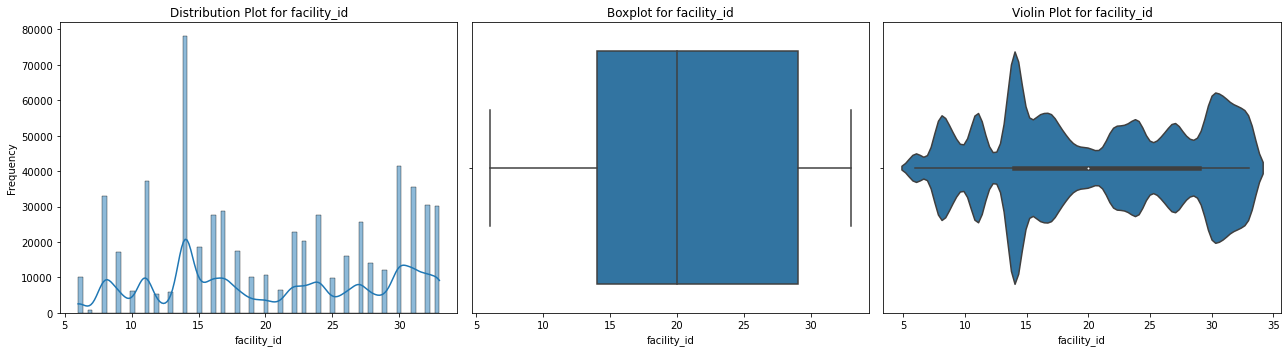

c:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


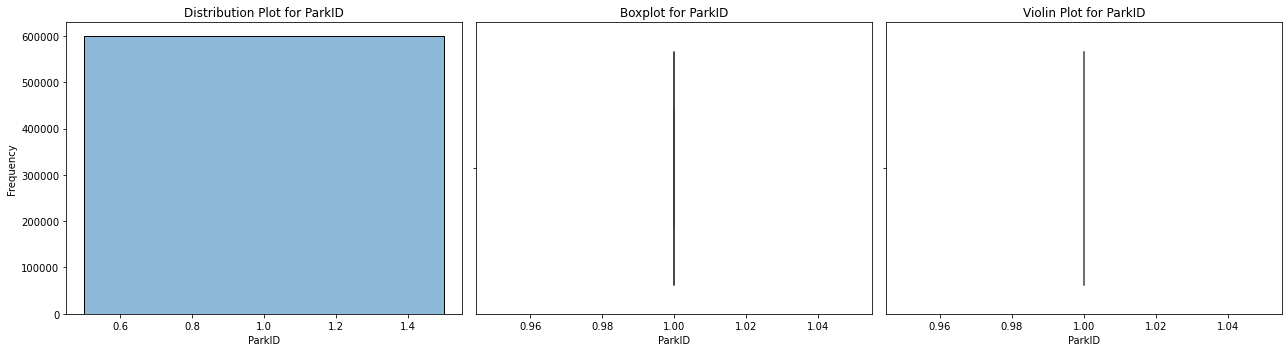

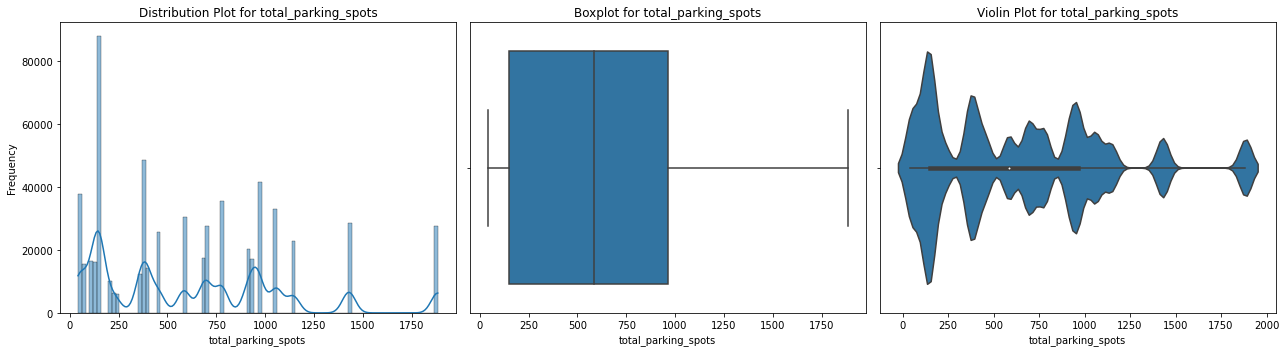

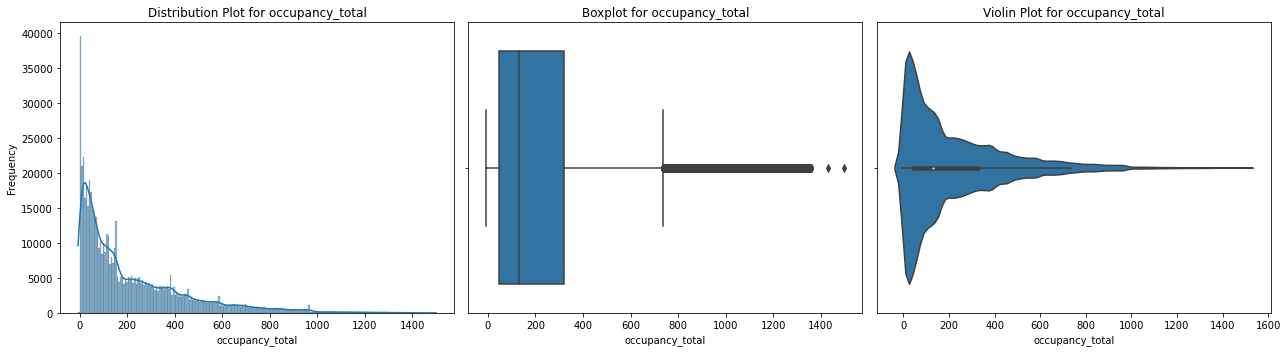

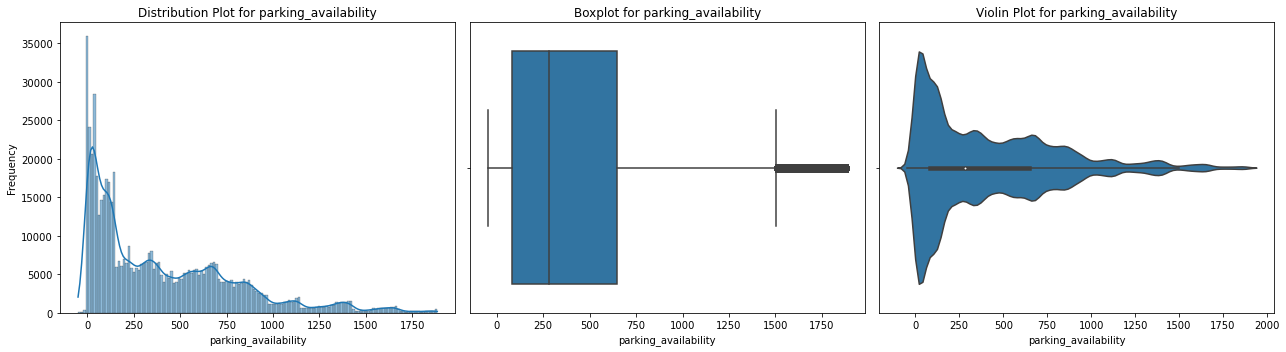

In [27]:
# Function to create varioous distribution plots for numeriacal columns
def create_distribution_plots(dataframe):
    # Check if the input is a DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input is not a DataFrame.")

    # Loop through each column in the DataFrame
    for column in dataframe.columns:
        # Check if the column is numerical
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            # Create a figure with subplots
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

            # Histogram with KDE
            sns.histplot(dataframe[column], kde=True, ax=axes[0])
            axes[0].set_title(f'Distribution Plot for {column}')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Frequency')

            # Boxplot
            sns.boxplot(x=dataframe[column], ax=axes[1])
            axes[1].set_title(f'Boxplot for {column}')
            axes[1].set_xlabel(column)
            axes[1].set_ylabel('')

            # Violin plot
            sns.violinplot(x=dataframe[column], ax=axes[2])
            axes[2].set_title(f'Violin Plot for {column}')
            axes[2].set_xlabel(column)
            axes[2].set_ylabel('')

            plt.tight_layout()
            plt.show()


create_distribution_plots(no_duplicate_df)

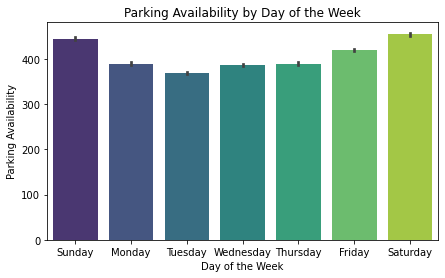

In [28]:
# Bar plot
plt.figure(figsize=(7, 4))
sns.barplot(x='day_of_week', y='parking_availability',
            data=no_duplicate_df, palette='viridis')
plt.title('Parking Availability by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Parking Availability')
plt.show()

<ipython-input-29-fec58c2726aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicate_df['time'] = pd.to_datetime(no_duplicate_df['time'],format='%H:%M:%S',exact=True).dt.time
<ipython-input-29-fec58c2726aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicate_df['time_category'] = no_duplicate_df['time'].apply(


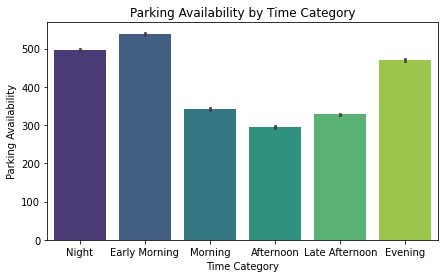

In [29]:
# Convert 'time' to datetime format
no_duplicate_df['time'] = pd.to_datetime(no_duplicate_df['time'],format='%H:%M:%S',exact=True).dt.time

# Define time categories
def categorize_time(hour):
    if 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'


# Create a new column 'time_category'
no_duplicate_df['time_category'] = no_duplicate_df['time'].apply(
    lambda x: categorize_time(x.hour))

# Bar plot grouped by time category
plt.figure(figsize=(7, 4))
sns.barplot(x='time_category', y='parking_availability',
            data=no_duplicate_df, palette='viridis')
plt.title('Parking Availability by Time Category')
plt.xlabel('Time Category')
plt.ylabel('Parking Availability')
plt.show()

In [30]:
no_duplicate_df['facility_name']

0         Narrabeen Car Park
1         Narrabeen Car Park
2         Narrabeen Car Park
3         Narrabeen Car Park
4         Narrabeen Car Park
                 ...        
618221      Revesby Car Park
618222      Revesby Car Park
618223      Revesby Car Park
618224      Revesby Car Park
618225      Revesby Car Park
Name: facility_name, Length: 599285, dtype: object

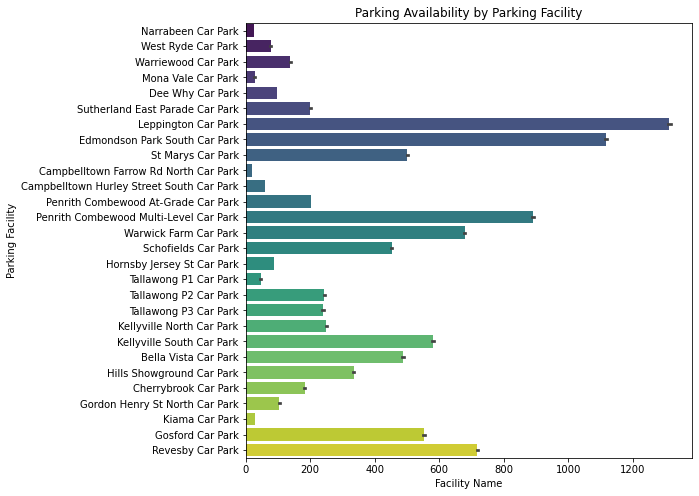

In [31]:
# Bar plot
plt.figure(figsize=(8, 8))
sns.barplot(y='facility_name', x='parking_availability',
            data=no_duplicate_df, palette='viridis',orient='h')
plt.title('Parking Availability by Parking Facility')
plt.xlabel('Facility Name')
# plt.xticks(rotation=45)
plt.ylabel('Parking Facility')
plt.show()

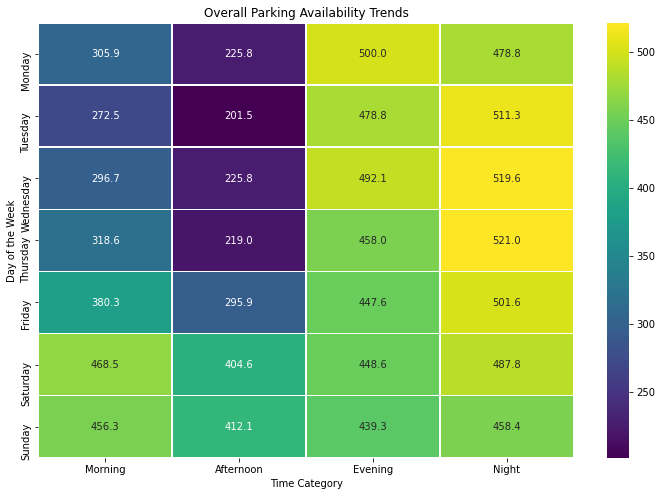

In [32]:
# Create a pivot table for heatmap
heatmap_data = no_duplicate_df.pivot_table(
    values='parking_availability', index='day_of_week', columns='time_category', aggfunc='mean')

# Define the order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define the order of time categories
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.loc[days_order, time_order], annot=True, cmap='viridis', fmt='.1f', linewidths=.5)
plt.title('Overall Parking Availability Trends')
plt.xlabel('Time Category')
plt.ylabel('Day of the Week')
plt.show()

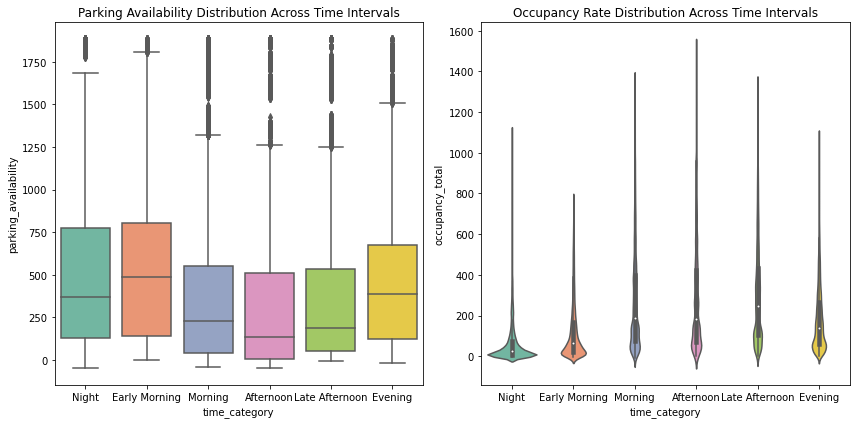

In [33]:
# Create a side-by-side boxplot or violin plot
plt.figure(figsize=(12, 6))

# Side-by-side boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='time_category', y='parking_availability',
            data=no_duplicate_df, palette='Set2')
plt.title('Parking Availability Distribution Across Time Intervals')

# Side-by-side violin plot
plt.subplot(1, 2, 2)
sns.violinplot(x='time_category', y='occupancy_total',
               data=no_duplicate_df, palette='Set2')
plt.title('Occupancy Rate Distribution Across Time Intervals')

plt.tight_layout()
plt.show()

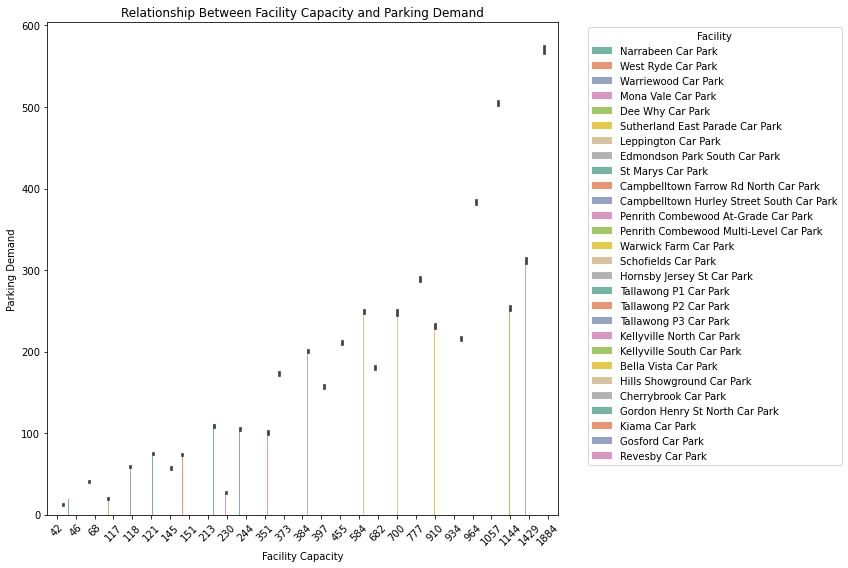

In [34]:
# Scatter plot
plt.figure(figsize=(12, 8))

# Adjust bar width and color palette
sns.barplot(x='total_parking_spots', y='occupancy_total',
            data=no_duplicate_df, hue='facility_name', palette='Set2', dodge=True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set titles and labels
plt.title('Relationship Between Facility Capacity and Parking Demand')
plt.xlabel('Facility Capacity')
plt.ylabel('Parking Demand')
plt.legend(title='Facility', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

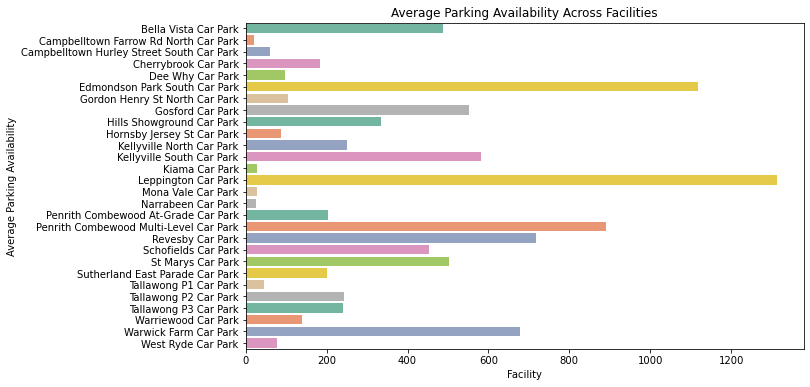

Facilities with consistently high parking availability: ['Bella Vista Car Park', 'Cherrybrook Car Park', 'Dee Why Car Park', 'Edmondson Park South Car Park', 'Gordon Henry St North Car Park', 'Gosford Car Park', 'Hills Showground Car Park', 'Hornsby Jersey St Car Park', 'Kellyville North Car Park', 'Kellyville South Car Park', 'Leppington Car Park', 'Penrith Combewood At-Grade Car Park', 'Penrith Combewood Multi-Level Car Park', 'Revesby Car Park', 'Schofields Car Park', 'St Marys Car Park', 'Sutherland East Parade Car Park', 'Tallawong P2 Car Park', 'Tallawong P3 Car Park', 'Warriewood Car Park', 'Warwick Farm Car Park', 'West Ryde Car Park']
Facilities with consistently low parking availability: ['Campbelltown Farrow Rd North Car Park', 'Campbelltown Hurley Street South Car Park', 'Kiama Car Park', 'Mona Vale Car Park', 'Narrabeen Car Park', 'Tallawong P1 Car Park']


In [35]:
# Calculate average parking availability for each facility
avg_availability = no_duplicate_df.groupby(
    'facility_name')['parking_availability'].mean().reset_index()

# Plot a bar chart to visualize the distribution of average parking availability
plt.figure(figsize=(10, 6))
sns.barplot(y='facility_name', x='parking_availability', data=avg_availability, palette='Set2',orient='h')
plt.title('Average Parking Availability Across Facilities')
plt.xlabel('Facility')
plt.ylabel('Average Parking Availability')
plt.show()

# Identify facilities with consistently high or low parking availability
threshold = 70  # Adjust the threshold based on your criteria
high_availability_facilities = avg_availability[avg_availability['parking_availability'] >= threshold]['facility_name']
low_availability_facilities = avg_availability[avg_availability['parking_availability'] < threshold]['facility_name']

print(f'Facilities with consistently high parking availability: {list(high_availability_facilities)}')
print(f'Facilities with consistently low parking availability: {list(low_availability_facilities)}')

<ipython-input-36-eb6a6f1b01d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicate_df['z_score'] = (no_duplicate_df['parking_availability'] -


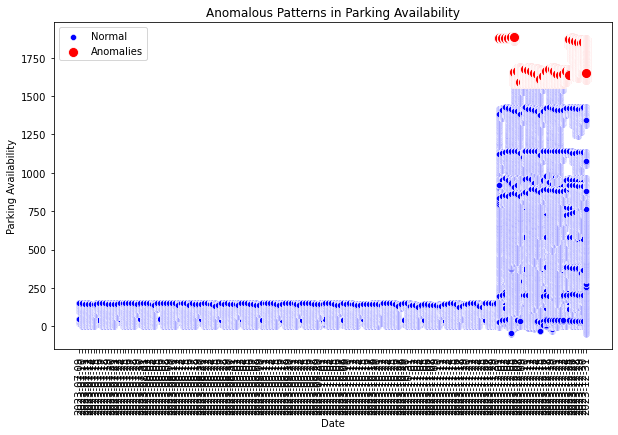

In [36]:
# Calculate z-scores for parking availability
no_duplicate_df['z_score'] = (no_duplicate_df['parking_availability'] -
                              no_duplicate_df['parking_availability'].mean()) / no_duplicate_df['parking_availability'].std()

# Set a threshold for anomaly detection (e.g., z-score greater than 3)
anomaly_threshold = 3
anomalies = no_duplicate_df[no_duplicate_df['z_score'] > anomaly_threshold]

# Visualize anomalies in a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='date', y='parking_availability',
                data=no_duplicate_df, label='Normal', color='blue')
sns.scatterplot(x='date', y='parking_availability', data=anomalies, label='Anomalies', color='red', s=100)
plt.title('Anomalous Patterns in Parking Availability')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Parking Availability')
plt.legend()
plt.show()

In [37]:
no_duplicate_df

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category,z_score
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night,-0.913345
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night,-0.913345
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night,-0.913345
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night,-0.913345
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night,-0.913345
...,...,...,...,...,...,...,...,...,...,...,...,...
618221,9,Revesby Car Park,1,1,934,52,Sunday,2023-12-31,23:19:07,882,Night,1.217343
618222,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:21:53,883,Night,1.219883
618223,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:31:53,883,Night,1.219883
618224,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:41:54,883,Night,1.219883


In [38]:
carparks_df_copy.loc[carparks_df_copy.parking_availability == 0]

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability
712,11,Narrabeen Car Park,1,1,46,46,Wednesday,2023-07-12,10:43:49,0
713,11,Narrabeen Car Park,1,1,46,46,Wednesday,2023-07-12,10:47:13,0
714,11,Narrabeen Car Park,1,1,46,46,Wednesday,2023-07-12,10:47:45,0
715,11,Narrabeen Car Park,1,1,46,46,Wednesday,2023-07-12,10:57:45,0
716,11,Narrabeen Car Park,1,1,46,46,Wednesday,2023-07-12,11:07:47,0
...,...,...,...,...,...,...,...,...,...,...
567946,7,Kiama Car Park,1,1,42,42,Sunday,2023-12-31,20:00:02,0
567948,7,Kiama Car Park,1,1,42,42,Sunday,2023-12-31,20:45:57,0
567950,7,Kiama Car Park,1,1,42,42,Sunday,2023-12-31,21:16:04,0
574013,8,Gosford Car Park,1,1,1057,1057,Tuesday,2023-12-05,10:03:58,0


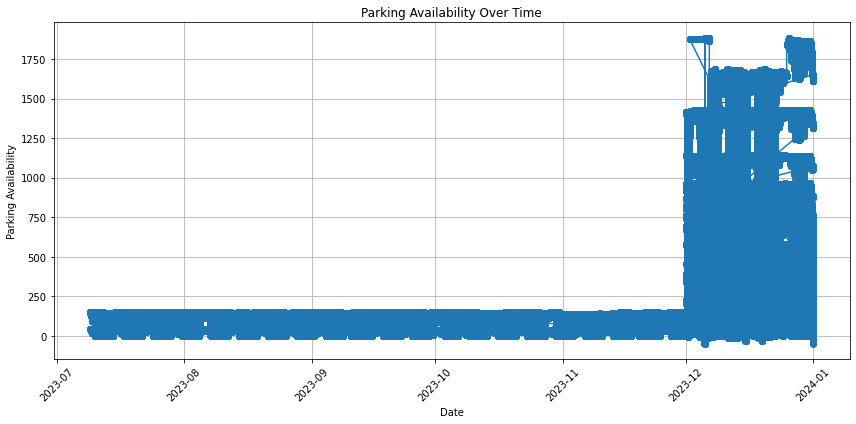

In [39]:
import matplotlib.pyplot as plt

# Convert 'date' and 'time' columns to datetime format
carparks_df_copy['datetime'] = pd.to_datetime(carparks_df_copy['date'] + ' ' + carparks_df_copy['time'])

# Set 'datetime' column as the index
carparks_df_copy.set_index('datetime', inplace=True)

# Plot parking availability over time
plt.figure(figsize=(12, 6))
plt.plot(carparks_df_copy.index, carparks_df_copy['parking_availability'], marker='o', linestyle='-')
plt.title('Parking Availability Over Time')
plt.xlabel('Date')
plt.ylabel('Parking Availability')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
len(carparks_df_copy)

618226

In [41]:
df1 = no_duplicate_df.copy()
df1.head()

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category,z_score
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night,-0.913345
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night,-0.913345
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night,-0.913345
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night,-0.913345
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night,-0.913345


In [42]:
import pandas as pd


# Read holiday information DataFrame
holiday_data = pd.read_csv('data/NSW_holidays_2023.csv')

# Convert 'date' column to datetime format
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%b %d')


# Extract month and day information and format it as 'Month Day'
holiday_data['date'] = holiday_data['date'].dt.strftime('%b %d')

# Create a set of holiday dates
holidays = set(holiday_data['date'])

# Create 'is_holiday' column based on whether the date is a holiday
df1['is_holiday'] = df1['date'].isin(holidays)

# Map True/False to 'yes'/'no' for 'is_holiday' column
df1['is_holiday'] = df1['is_holiday'].map({True: 'Yes', False: 'No'})

# Display the DataFrame to verify changes
df1.head()


,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category,z_score,is_holiday
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night,-0.913345,No
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night,-0.913345,No
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night,-0.913345,No
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night,-0.913345,No
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night,-0.913345,No


In [43]:
df1.is_holiday.value_counts()

No    599285
Name: is_holiday, dtype: int64

In [44]:
len(df1)

599285

In [45]:
coords_df = pd.read_json('data/coords.json')
coords_df.head()

,facility_id,longitude,latitude
0,6,-33.756009,151.154528
1,7,-34.672518,150.854695
2,8,-33.423883,151.341711
3,9,-33.952460,151.014838
4,10,-33.697777,151.300667


In [46]:
final_df = df1.copy()

final_df = final_df.merge(coords_df, on = 'facility_id',how = 'left')

final_df.sort_values(by = 'facility_id')
final_df.head()

,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category,z_score,is_holiday,longitude,latitude
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night,-0.913345,No,-33.713514,151.297315
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night,-0.913345,No,-33.713514,151.297315
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night,-0.913345,No,-33.713514,151.297315
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night,-0.913345,No,-33.713514,151.297315
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night,-0.913345,No,-33.713514,151.297315


In [47]:
import folium

# Create a map centered at the mean latitude and longitude
m = folium.Map(location=[final_df['latitude'].mean(), final_df['longitude'].mean()], zoom_start=12)

# Add markers for each parking spot
for idx, row in final_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['facility_name']).add_to(m)

# Display the map
m


KeyboardInterrupt: 

In [68]:
final_df.to_csv(r"C:\Users\HP\Desktop\Moringa Projects\Capstone\phase5-capstone-project\df.csv", index = False)

In [52]:
import pandas as pd

# Assuming 'date' column is in the format 'YYYY-MM-DD'
# Convert 'date' column to datetime object
final_df['date'] = pd.to_datetime(final_df['date'])

# Extract month name from the 'date' column and assign it to a new 'month' column
final_df['month'] = final_df['date'].dt.strftime('%B')

# Display the DataFrame with the new 'month' column
final_df



,facility_id,facility_name,ParkID,zone_id,total_parking_spots,occupancy_total,day_of_week,date,time,parking_availability,time_category,z_score,is_holiday,longitude,latitude,month
0,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:03:25,43,Night,-0.913345,No,-33.713514,151.297315,July
1,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:13:27,43,Night,-0.913345,No,-33.713514,151.297315,July
2,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:23:29,43,Night,-0.913345,No,-33.713514,151.297315,July
3,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:33:30,43,Night,-0.913345,No,-33.713514,151.297315,July
4,11,Narrabeen Car Park,1,1,46,3,Sunday,2023-07-09,00:43:32,43,Night,-0.913345,No,-33.713514,151.297315,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599280,9,Revesby Car Park,1,1,934,52,Sunday,2023-12-31,23:19:07,882,Night,1.217343,No,-33.952460,151.014838,December
599281,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:21:53,883,Night,1.219883,No,-33.952460,151.014838,December
599282,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:31:53,883,Night,1.219883,No,-33.952460,151.014838,December
599283,9,Revesby Car Park,1,1,934,51,Sunday,2023-12-31,23:41:54,883,Night,1.219883,No,-33.952460,151.014838,December


## __Average Occupancy Total for each Month for each Facility__

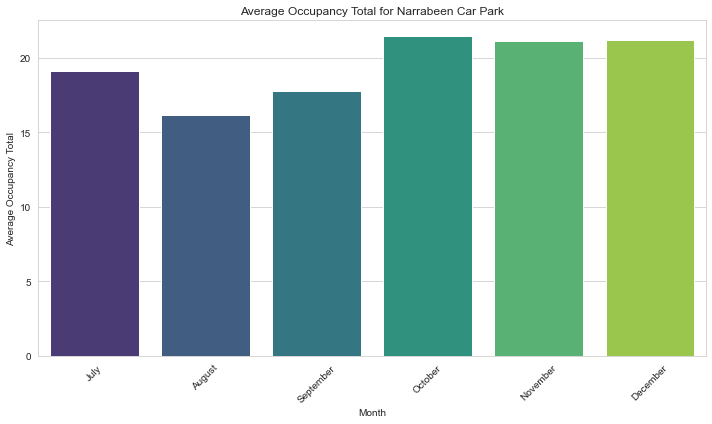

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for the Narrabeen Car Park facility
narrabeen_data = final_df[final_df['facility_name'] == 'Narrabeen Car Park']

# Group the data by month and calculate the average occupancy total
narrabeen_month_avg = narrabeen_data.groupby('month')['occupancy_total'].mean().reset_index()

# Set the style of the plot
sns.set_style("whitegrid")

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=narrabeen_month_avg, x='month', y='occupancy_total', palette='viridis')
plt.title('Average Occupancy Total for Narrabeen Car Park')
plt.xlabel('Month')
plt.ylabel('Average Occupancy Total')
plt.xticks(ticks=range(6), labels=['July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.tight_layout()
plt.show()



In [58]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # List of unique facility names
# facility_names = final_df['facility_name'].unique()

# # Set the style of the plot
# sns.set_style("whitegrid")

# # Create subplots
# fig, axes = plt.subplots(nrows=len(facility_names), ncols=1, figsize=(10, len(facility_names) * 5), sharex=True)

# # Iterate over each facility name
# for i, facility_name in enumerate(facility_names):
#     # Filter data for the current facility
#     facility_data = final_df[final_df['facility_name'] == facility_name]
    
#     # Group the data by month and calculate the average occupancy total
#     facility_month_avg = facility_data.groupby('month')['occupancy_total'].mean().reset_index()
    
#     # Create bar plot for the current facility
#     sns.barplot(data=facility_month_avg, x='month', y='occupancy_total', palette='viridis', ax=axes[i])
    
#     # Set title and labels for the current subplot
#     axes[i].set_title(f'Average Occupancy Total for {facility_name}')
#     axes[i].set_xlabel('Month')
#     axes[i].set_ylabel('Average Occupancy Total')
#     axes[i].set_xticks(range(6))
#     axes[i].set_xticklabels(['July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
#     axes[i].tick_params(axis='x', labelrotation=45)
#     axes[i].grid(True)

# # Adjust layout
# plt.tight_layout()
# plt.show()


## __Total Number of Parking Spots in each Facility__

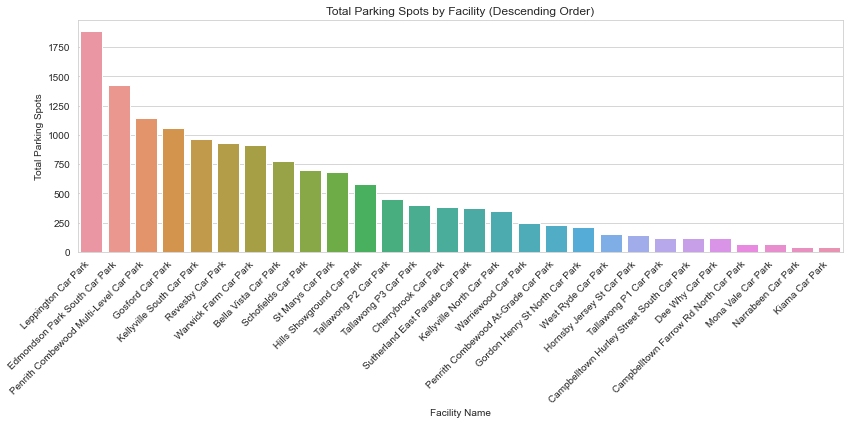

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by facility name and sum the total parking spots
facility_parking_spots = final_df.groupby('facility_name')['total_parking_spots'].first().reset_index()

# Sort the DataFrame by total parking spots in descending order
facility_parking_spots = facility_parking_spots.sort_values(by='total_parking_spots', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='facility_name', y='total_parking_spots', data=facility_parking_spots)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Facility Name')
plt.ylabel('Total Parking Spots')
plt.title('Total Parking Spots by Facility (Descending Order)')
plt.tight_layout()
plt.show()




## __Average Occupancy Total per Day for each Facility__

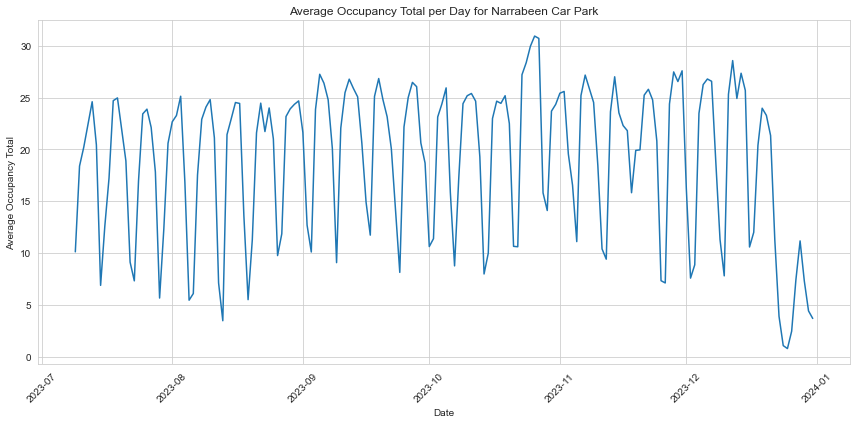

In [62]:
# Filter the data for the Narrabeen facility
narrabeen_data = final_df[final_df['facility_name'] == 'Narrabeen Car Park']

# Group by date and calculate the mean occupancy total
average_occupancy_per_day = narrabeen_data.groupby('date')['occupancy_total'].mean().reset_index()

# Plot the average occupancy per day
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='occupancy_total', data=average_occupancy_per_day)
plt.xlabel('Date')
plt.ylabel('Average Occupancy Total')
plt.title('Average Occupancy Total per Day for Narrabeen Car Park')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


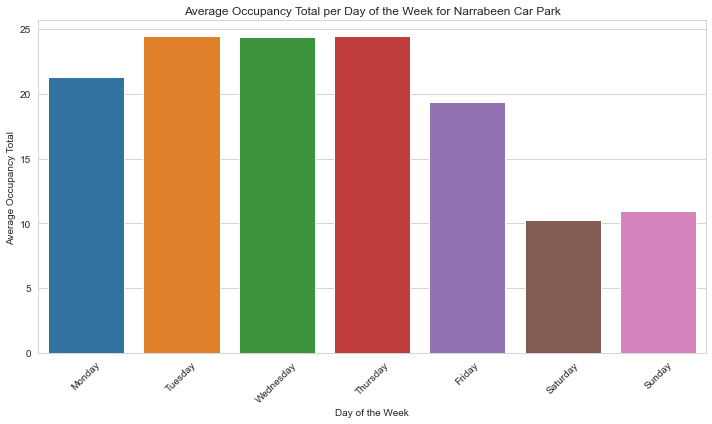

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'date' column to datetime format
final_df['date'] = pd.to_datetime(final_df['date'])

# Filter the data for the Narrabeen facility
narrabeen_data = final_df[final_df['facility_name'] == 'Narrabeen Car Park']

# Group by the day of the week and calculate the mean occupancy total
average_occupancy_per_day_of_week = narrabeen_data.groupby(narrabeen_data['date'].dt.day_name())['occupancy_total'].mean().reset_index()

# Define the order of the days of the week
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x='date', y='occupancy_total', data=average_occupancy_per_day_of_week, order=days_of_week_order)
plt.xlabel('Day of the Week')
plt.ylabel('Average Occupancy Total')
plt.title('Average Occupancy Total per Day of the Week for Narrabeen Car Park')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


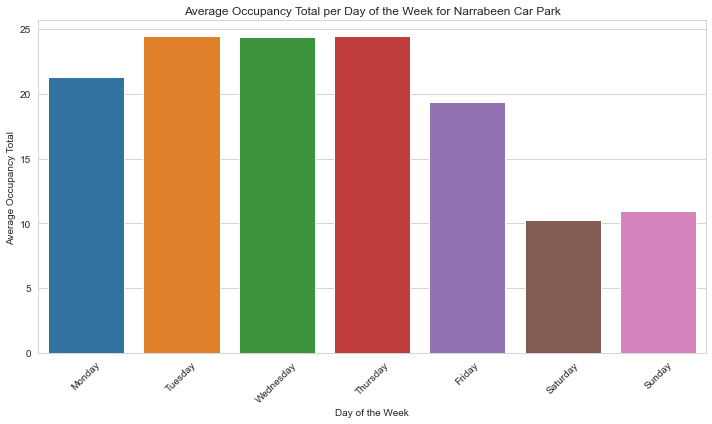

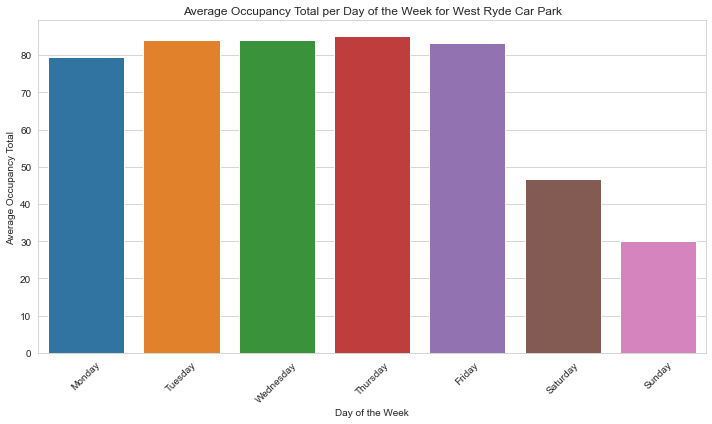

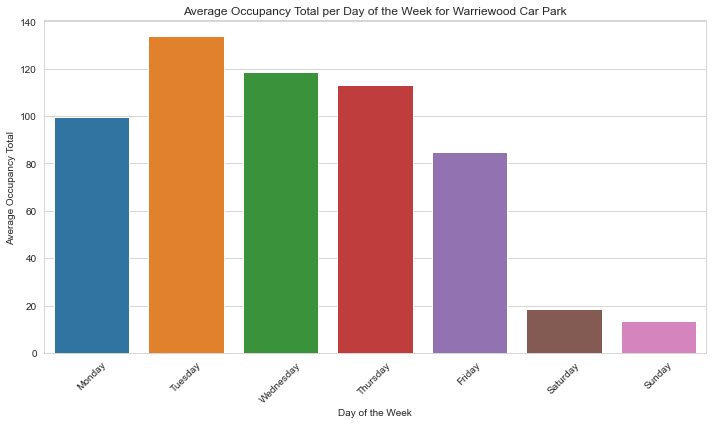

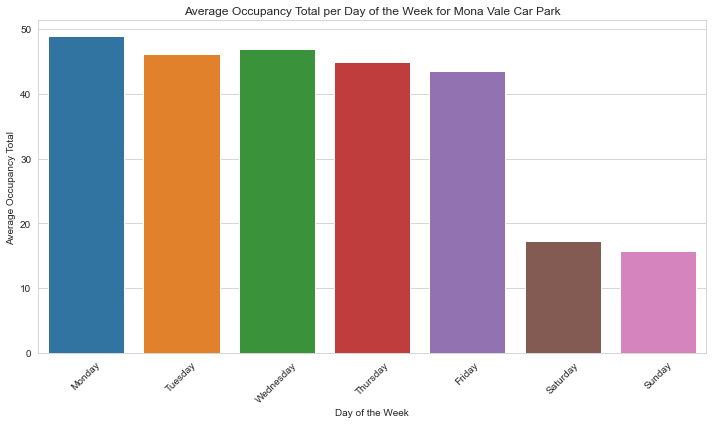

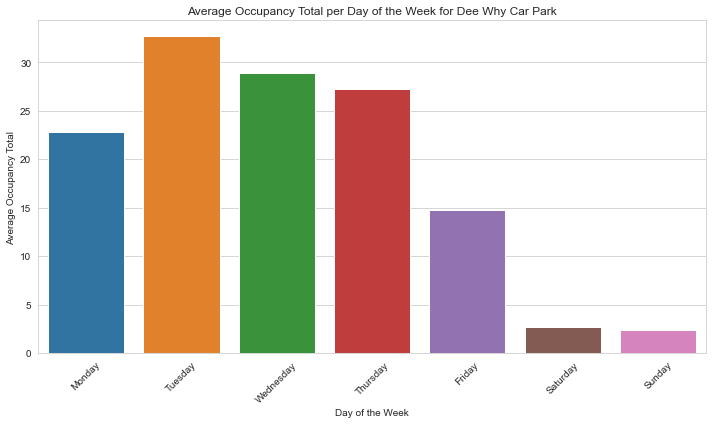

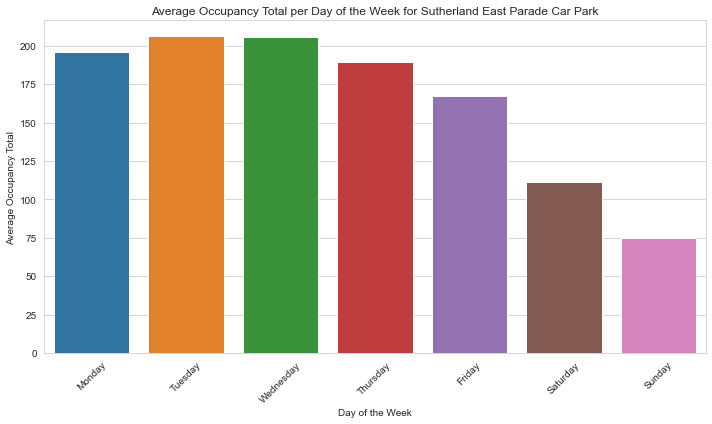

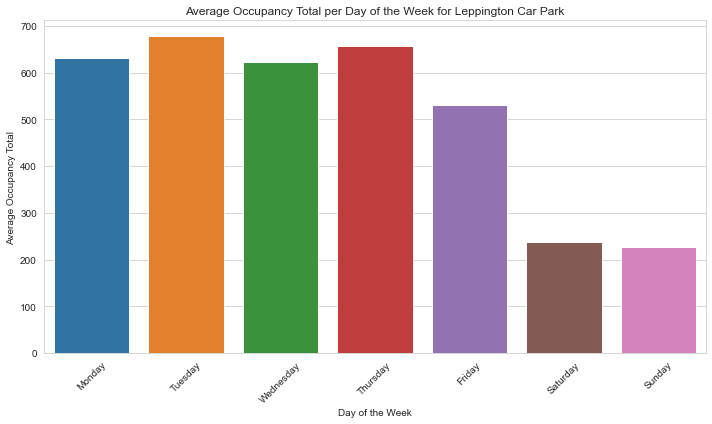

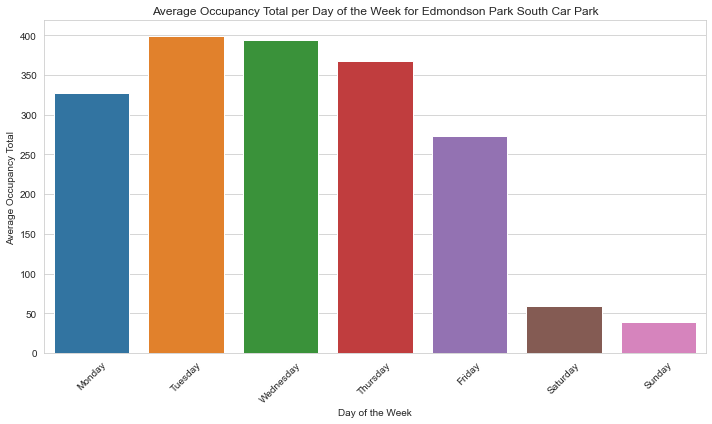

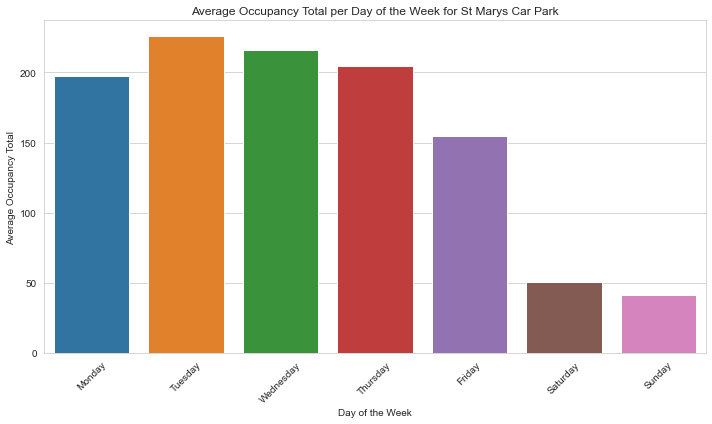

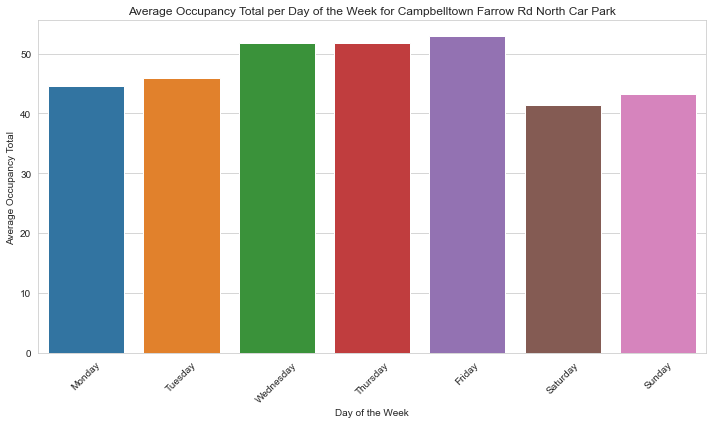

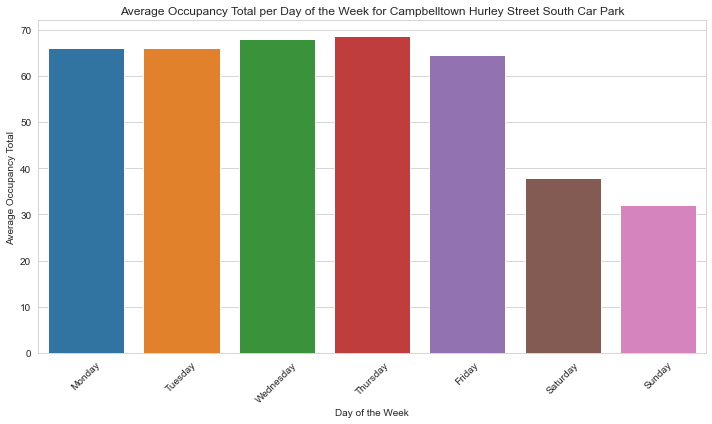

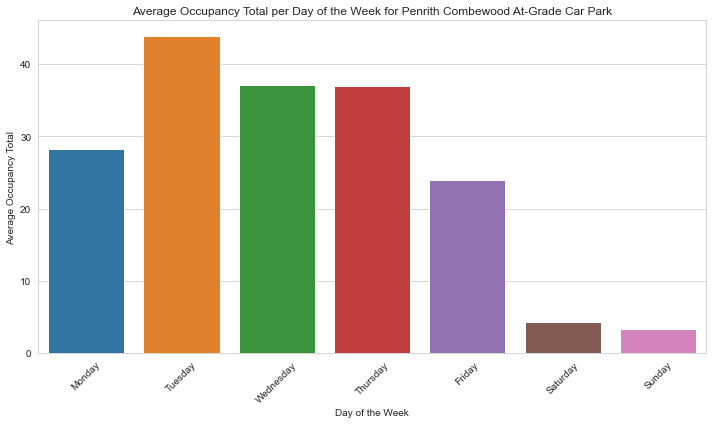

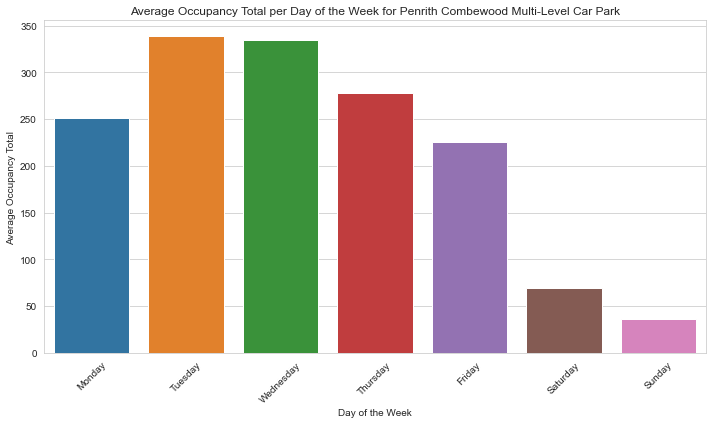

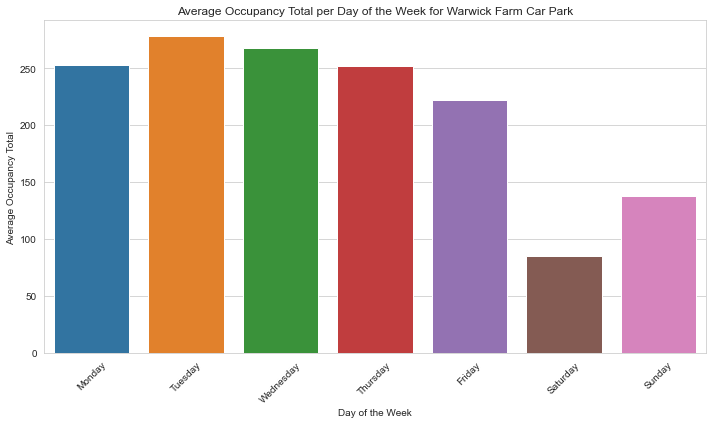

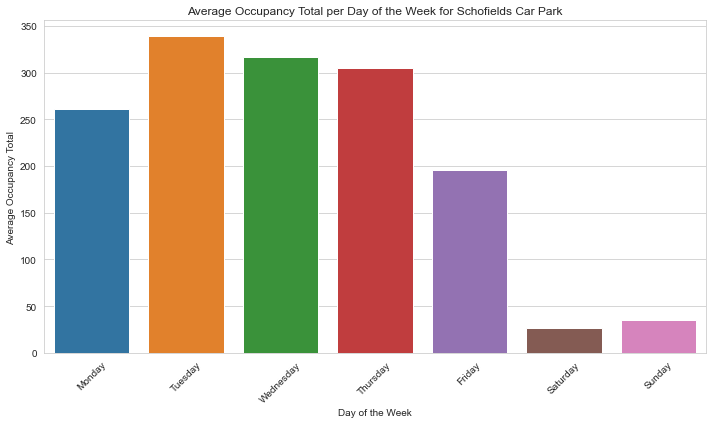

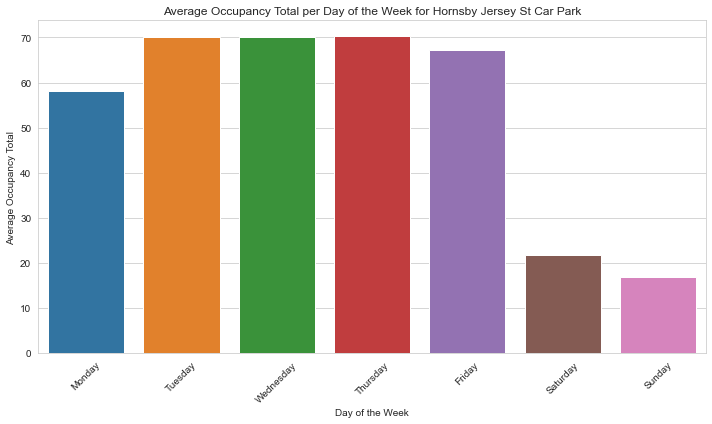

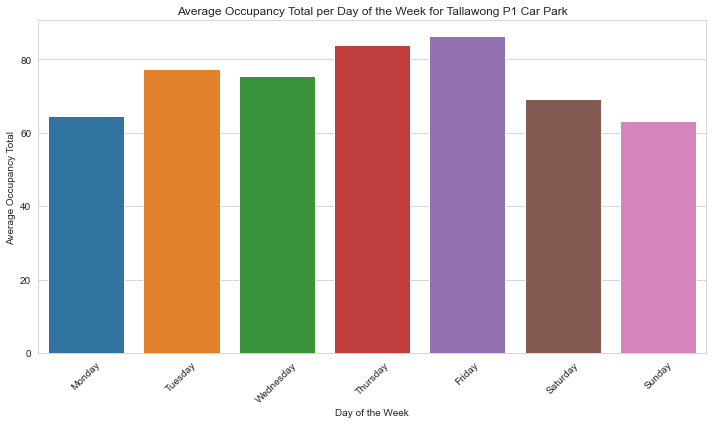

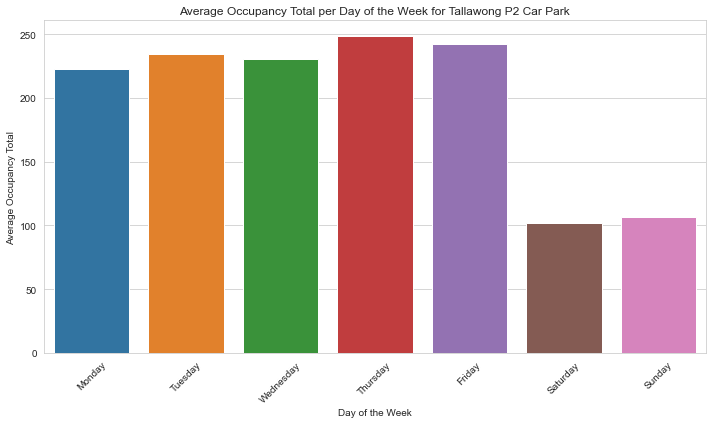

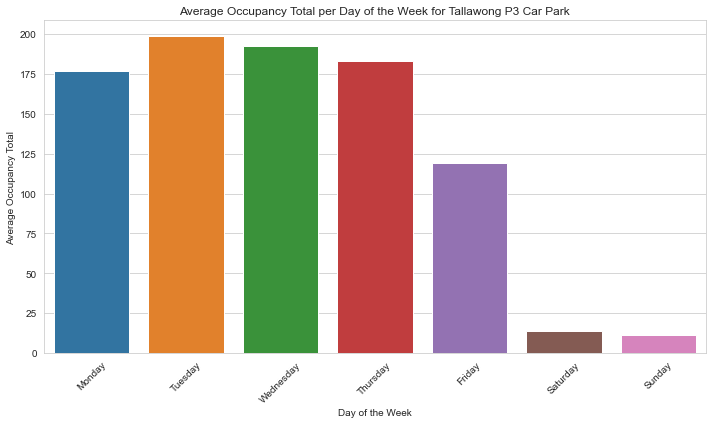

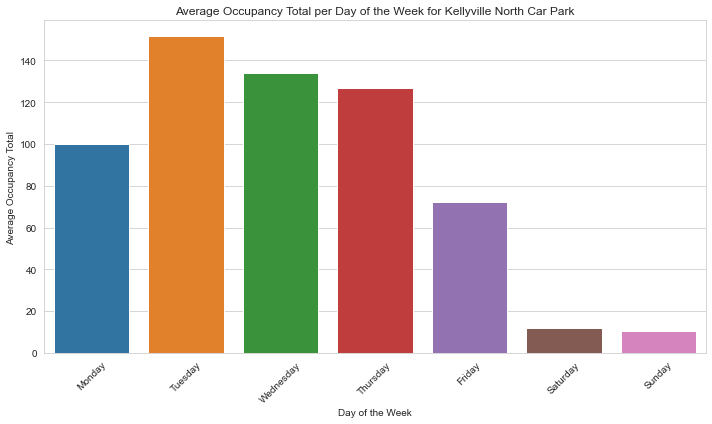

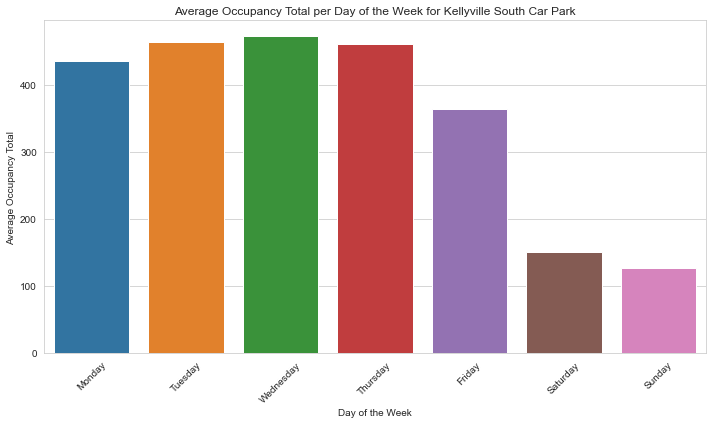

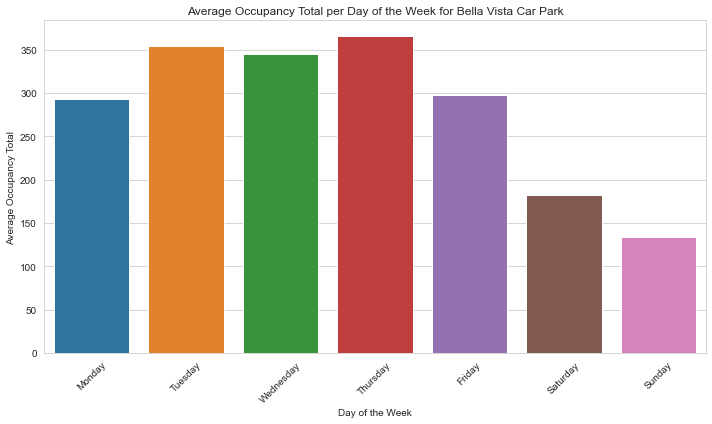

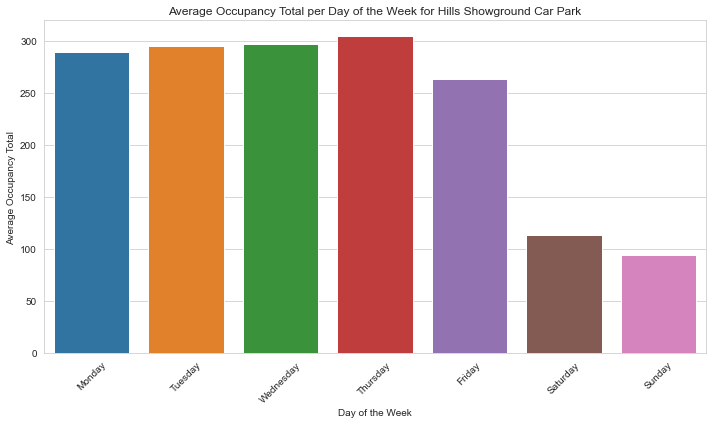

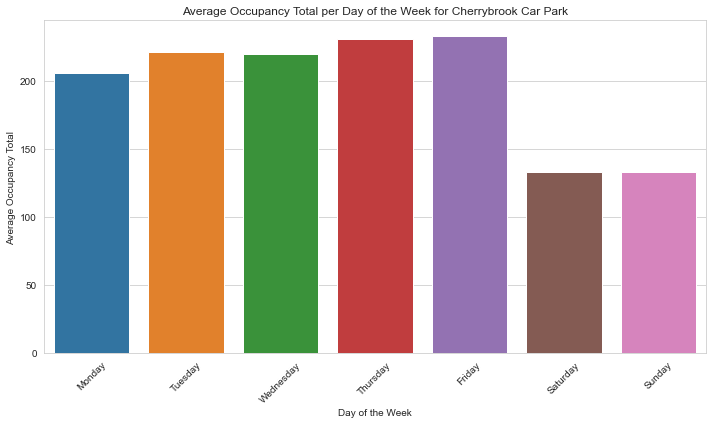

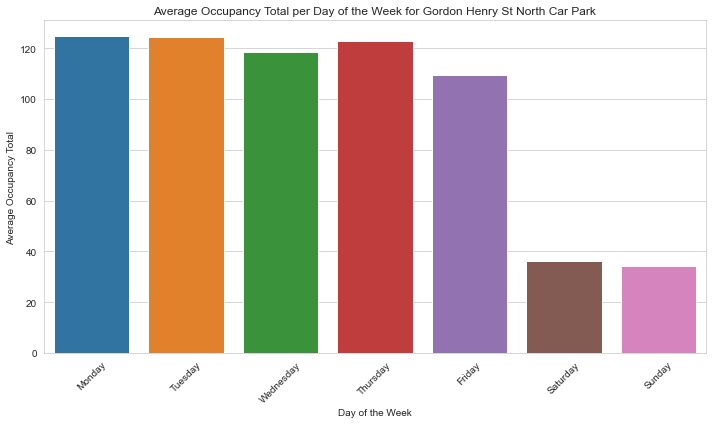

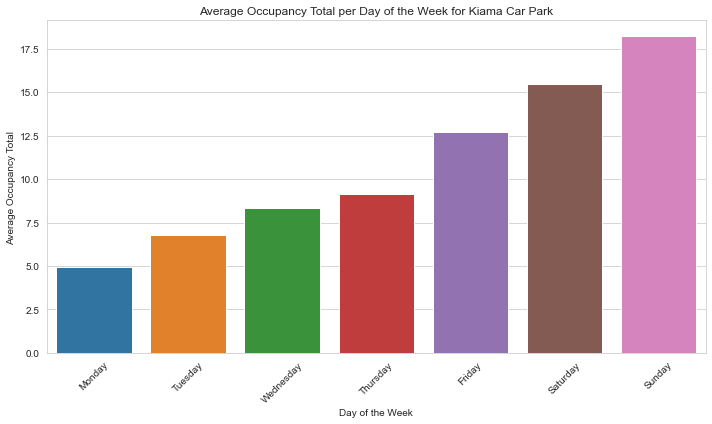

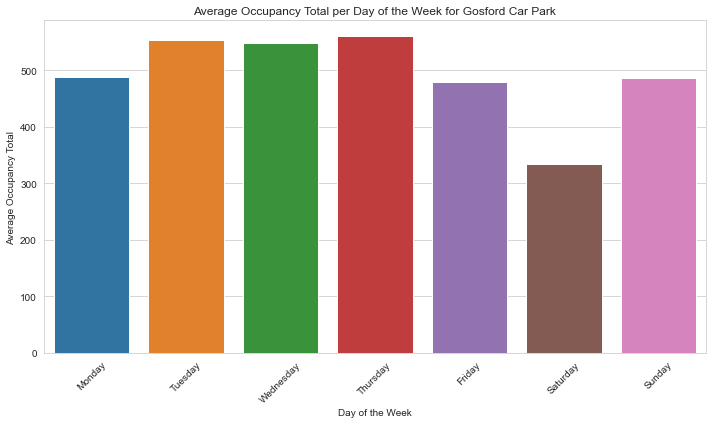

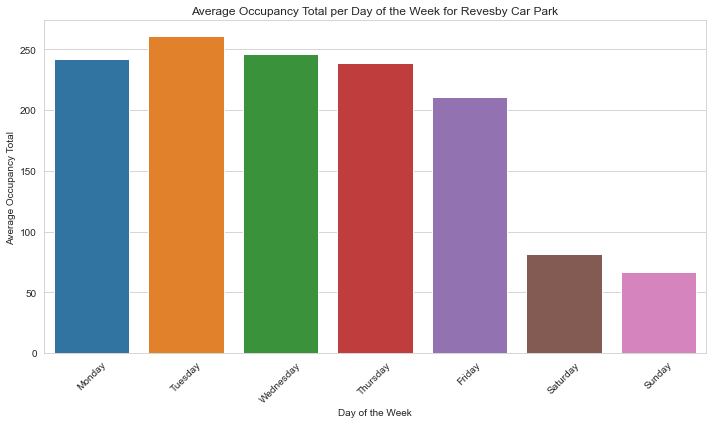

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'date' column to datetime format
final_df['date'] = pd.to_datetime(final_df['date'])

# Group by facility name and day of the week, and calculate the mean occupancy total
average_occupancy_per_facility_and_day_of_week = final_df.groupby([final_df['facility_name'], final_df['date'].dt.day_name()])['occupancy_total'].mean().reset_index()

# Define the order of the days of the week
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterate through each facility name
for facility_name in final_df['facility_name'].unique():
    # Filter data for the current facility
    facility_data = average_occupancy_per_facility_and_day_of_week[average_occupancy_per_facility_and_day_of_week['facility_name'] == facility_name]
    
    # Plot the bar graph
    plt.figure(figsize=(10, 6))
    sns.barplot(x='date', y='occupancy_total', data=facility_data, order=days_of_week_order)
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Occupancy Total')
    plt.title(f'Average Occupancy Total per Day of the Week for {facility_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
